In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){return false;}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pprint import pprint
from datetime import datetime, timedelta

In [3]:
with open('logins.json') as log:
    logins = json.load(log)

In [4]:
print(logins.keys())
print(len(logins['login_time']))

dict_keys(['login_time'])
93142


In [5]:
login_df = pd.DataFrame(logins)
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [6]:
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null object
dtypes: object(1)
memory usage: 727.8+ KB


In [138]:
login_df.describe()

,login_time
count,93142
unique,92265
top,1970-03-29 03:24:57
freq,3


From exploring the data, we saw that there are 93142 entries all non-null object with 93142 uniques. We need to preprocess the login time.

In [7]:
login_df.login_time = login_df.login_time.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
print(type(login_df.login_time[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [8]:
login_data = pd.Series(range(len(login_df)), index = login_df.login_time)
login_data.head()

login_time
1970-01-01 20:13:18    0
1970-01-01 20:16:10    1
1970-01-01 20:16:37    2
1970-01-01 20:16:36    3
1970-01-01 20:26:21    4
dtype: int64

Resample logins into 15-min bins

In [9]:
fifteen_min_data=login_data.resample('15T').count()
print('First timestamp in the data: {}'.format(fifteen_min_data.index.min()))
print('Last timestamp in the data: {}'.format(fifteen_min_data.index.max()))
fifteen_min_data.head()

First timestamp in the data: 1970-01-01 20:00:00
Last timestamp in the data: 1970-04-13 18:45:00


login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, dtype: int64

In [10]:
# Create a dataframe of the time series
day_data = pd.DataFrame(fifteen_min_data, columns =['count'])

# Create a column converting the timestamp to it's corresponding day of the week 
# 0 = Monday | 1 = Tuesday | 2 = Wednesday | 3 = Thursday | 4 = Friday | 5 = Saturday | 6 = Sunday
day_data['day_of_week'] = fifteen_min_data.index.dayofweek
day_data.head()

,count,day_of_week
login_time,,
1970-01-01 20:00:00,2,3
1970-01-01 20:15:00,6,3
1970-01-01 20:30:00,9,3
1970-01-01 20:45:00,7,3
1970-01-01 21:00:00,1,3


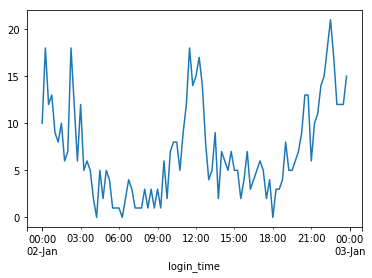

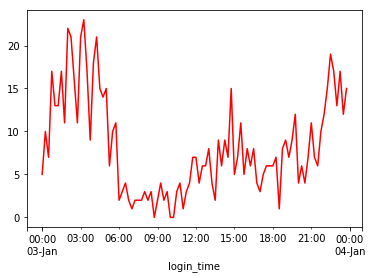

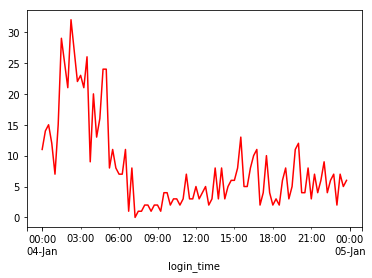

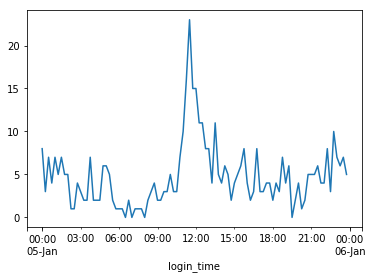

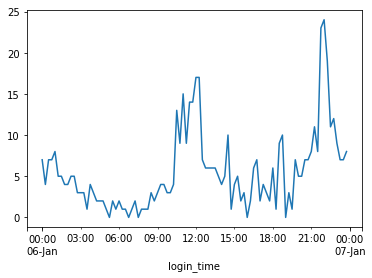

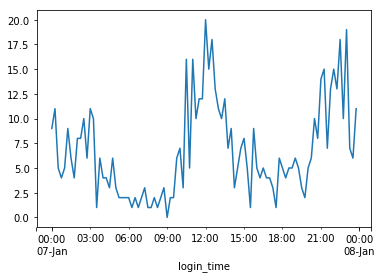

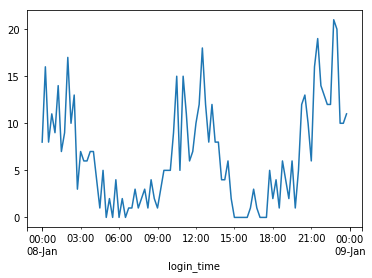

In [11]:
for i in range(2,9):
    #extract daily timestamps one by one
    day = '1970-01-{}'.format(i)
    date = fifteen_min_data.loc[day:day]
    
    #If the current day is a weekend [Saturday or Sunday] color it red
    if i in [3,4]:
        date.plot(color='r')
        plt.show()
    #Plot weekdays as blue
    else:
        date.plot()
        plt.show()

In [12]:
def plot_day(df, day, color = None):
    week = {'monday':0,'tuesday':1,'wednesday':2,'thursday':3,'friday':4,'saturday':5,'sunday':6}
    map_day = week[day]
    
    filtered_day = df[df.day_of_week == map_day]
    times = filtered_day.index
    filtered_day = filtered_day.groupby([times.hour.rename('hour'), times.minute.rename('minute')]).sum()

    
    filtered_day['count'].plot(color = color)
    plt.xlabel('Time of Day')
    plt.ylabel('Login Count')
    plt.title(day.title())
    plt.xticks([])

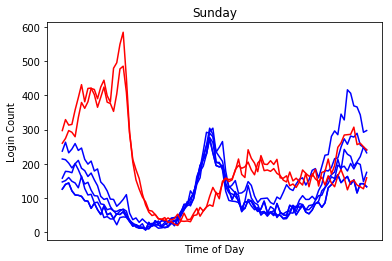

In [13]:
plot_day(day_data, 'monday', color = 'blue')

plot_day(day_data, 'monday', color = 'blue')

plot_day(day_data, 'tuesday', color = 'blue')

plot_day(day_data, 'wednesday', color = 'blue')

plot_day(day_data, 'thursday', color = 'blue')

plot_day(day_data, 'friday', color = 'blue')

plot_day(day_data, 'saturday', color = 'red')

plot_day(day_data, 'sunday', color = 'red')

The Neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1.What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
The ratio of login counts between Gotham and Metropolis at most active time of a day would be the key measure of success of this experiment.

2.Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a.how you will implement the experiment 
5 week period with no holiday, we will reimburse the toll cost in this order:
1st week, we will reimburse both directions
2nd week, we will not reimburse
3rd week, we will reimburse to Metropolis
4th week, we will not reimburse
5th week, we will reimburse Gotham
The control weeks of 2nd and 4th is to make sure drivers who think the reimburse period is still going on.

b.what statistical test(s) you will conduct to verify the significance of the observation
We will use two proportion z-test because we are interested in the ratio of logins between two cities and have more than 30 samples.

c.how you would interpret the results and provide recommendations to the city operations team along with any caveats.
The key measurement is the ratio, with a z-test we see if there is a significant change when Ultimate reimburse the toll cost.
However, even if we find a significant change, it is not necessarily a good thing. Another measurement we need to take into account is the total cost of tolls versus the total increased revenue during the reimbursement period.
Unless it is a gain or an increase, no matter how many more logins there are, it will be in vain.


In [14]:
with open('ultimate_data_challenge.json') as fh:
    data = json.load(fh)

In [15]:
pprint(data[0])
print('\n')
pprint(data[0].keys())

{'avg_dist': 3.67,
 'avg_rating_by_driver': 5.0,
 'avg_rating_of_driver': 4.7,
 'avg_surge': 1.1,
 'city': "King's Landing",
 'last_trip_date': '2014-06-17',
 'phone': 'iPhone',
 'signup_date': '2014-01-25',
 'surge_pct': 15.4,
 'trips_in_first_30_days': 4,
 'ultimate_black_user': True,
 'weekday_pct': 46.2}


dict_keys(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver', 'avg_surge', 'last_trip_date', 'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'])


In [16]:
data_dict = {'avg_dist':[], 'avg_rating_by_driver':[], 'avg_rating_of_driver':[], 'avg_surge':[], 'city':[],
         'last_trip_date':[], 'phone':[], 'signup_date':[], 'surge_pct':[], 'trips_in_first_30_days':[],
         'ultimate_black_user':[], 'weekday_pct':[]}

In [17]:
for i in range(len(data)):
    data_dict['avg_dist'].append(data[i]['avg_dist'])
    data_dict['avg_rating_by_driver'].append(data[i]['avg_rating_by_driver'])
    data_dict['avg_rating_of_driver'].append(data[i]['avg_rating_of_driver'])
    data_dict['avg_surge'].append(data[i]['avg_surge'])
    data_dict['city'].append(data[i]['city'])
    data_dict['last_trip_date'].append(data[i]['last_trip_date'])
    data_dict['phone'].append(data[i]['phone'])
    data_dict['signup_date'].append(data[i]['signup_date'])
    data_dict['surge_pct'].append(data[i]['surge_pct'])
    data_dict['trips_in_first_30_days'].append(data[i]['trips_in_first_30_days'])
    data_dict['ultimate_black_user'].append(data[i]['ultimate_black_user'])
    data_dict['weekday_pct'].append(data[i]['weekday_pct'])

In [18]:
data_df = pd.DataFrame(data_dict)
data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [19]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [20]:
data_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [21]:
data_df.last_trip_date = data_df.last_trip_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data_df.signup_date = data_df.signup_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [22]:
most_recent_day = data_df.last_trip_date.max()
print('Most Recent Trip Timestamp: {}'.format(most_recent_day))
cutoff = most_recent_day - timedelta(30)
print('30 Day Retention Cutoff: {}'.format(cutoff))

Most Recent Trip Timestamp: 2014-07-01 00:00:00
30 Day Retention Cutoff: 2014-06-01 00:00:00


In [23]:
def retained(x):
    if x <= cutoff:
        return 1
    else:
        return 0

In [24]:
data_df['retained'] = data_df.last_trip_date.apply(lambda x: retained(x))

In [25]:
data_df = data_df.drop('last_trip_date', axis = 1)
data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,2014-01-25,15.4,4,True,46.2,0
1,8.26,5.0,5.0,1.00,Astapor,Android,2014-01-29,0.0,0,False,50.0,1
2,0.77,5.0,4.3,1.00,Astapor,iPhone,2014-01-06,0.0,3,False,100.0,1
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,2014-01-10,20.0,9,True,80.0,0
4,3.13,4.9,4.4,1.19,Winterfell,Android,2014-01-27,11.8,14,False,82.4,1


In [26]:
num_of_retained_users = len(data_df[data_df.retained == 1].retained)
num_of_lost_users = len(data_df[data_df.retained == 0].retained)
print('Users Retained: {}'.format(num_of_retained_users))
print('Users Lost: {}'.format(num_of_lost_users))
print('Percentage of Users Retained: {}'.format(num_of_retained_users / (num_of_retained_users + num_of_lost_users)))

Users Retained: 31690
Users Lost: 18310
Percentage of Users Retained: 0.6338


In [27]:
driver_avg_fill = data_df.avg_rating_of_driver.describe()['mean']
user_avg_fill = data_df.avg_rating_by_driver.describe()['mean']

In [28]:
data_df.avg_rating_by_driver = data_df.avg_rating_by_driver.fillna(driver_avg_fill)
data_df.avg_rating_of_driver = data_df.avg_rating_of_driver.fillna(user_avg_fill)

In [29]:
data_df = data_df.drop(['phone','signup_date','city'], axis = 1)

In [30]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
retained                  50000 non-null int64
dtypes: bool(1), float64(6), int64(2)
memory usage: 3.1 MB


In [31]:
from sklearn.model_selection import train_test_split

In [32]:
x_data = data_df.drop('retained', axis = 1)
y_data = data_df.retained

In [33]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

In [35]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classify', LinearSVC(loss = 'hinge'))
])

In [36]:
param_grid = [{'classify__C':[0.01,0.1,1,10,100]}]

In [37]:
svc_clf = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5)

In [38]:
svc_clf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classify', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'classify__C': [0.01, 0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [39]:
print('Best Accuracy Score: {}'.format(svc_clf.best_score_))

Best Accuracy Score: 0.6626


In [40]:
svm_preds = svc_clf.predict(X_test)

In [45]:
svm_accuracy= accuracy_score(y_test, svm_preds)

In [46]:
from sklearn.metrics import classification_report

In [47]:
print(classification_report(y_test, svm_preds))
print('Test Accuracy: {}'.format(svm_accuracy))

             precision    recall  f1-score   support

          0       0.71      0.14      0.23      5477
          1       0.66      0.97      0.79      9523

avg / total       0.68      0.66      0.58     15000

Test Accuracy: 0.6646


In [48]:
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

In [49]:
pca_pipe = Pipeline([
    ('scaler',StandardScaler(with_mean=False)),
    ('reduce_dim',PCA()),
    ('classify',LinearSVC())
])

In [50]:
N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [0.01,0.1,1, 10, 100, 1000]

In [51]:
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    }
]

In [52]:
svm_decomp = GridSearchCV(pca_pipe, cv=5, n_jobs=1, param_grid=param_grid)

In [53]:
svm_decomp.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=False, with_std=True)), ('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'reduce_dim': [PCA(copy=True, iterated_power=7, n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=8, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, ver...n chi2 at 0x1185a0510>)], 'reduce_dim__k': [2, 4, 8], 'classify__C': [0.01, 0.1, 1, 10, 100, 1000]}],
       pre_di

In [54]:
decomp_preds = svm_decomp.predict(X_test)

In [55]:
decomp_accuracy = accuracy_score(y_test, decomp_preds)

In [56]:
print(classification_report(y_test, decomp_preds))
print('Test Accuracy: {}'.format(decomp_accuracy))

             precision    recall  f1-score   support

          0       0.64      0.28      0.39      5477
          1       0.69      0.91      0.78      9523

avg / total       0.67      0.68      0.64     15000

Test Accuracy: 0.679


In [57]:
from sklearn.ensemble import RandomForestClassifier


In [58]:
param_grid = {'n_estimators':[100,200,300,400,500],
              'max_leaf_nodes':[10,15,20,25]}

In [59]:
forest_clf = RandomForestClassifier()

In [60]:
forest_cv = GridSearchCV(forest_clf, param_grid = param_grid, cv=5)

In [61]:
forest_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 300, 400, 500], 'max_leaf_nodes': [10, 15, 20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [62]:
print('Best Random Forest Score: {}'.format(forest_cv.best_score_))
forest_preds = forest_cv.predict(X_test)
forest_accuracy = accuracy_score(y_test, forest_preds)
print(classification_report(y_test, forest_preds))
print('Test Accuracy: {}'.format(forest_accuracy))

Best Random Forest Score: 0.7483142857142857
             precision    recall  f1-score   support

          0       0.71      0.50      0.59      5477
          1       0.75      0.89      0.81      9523

avg / total       0.74      0.74      0.73     15000

Test Accuracy: 0.7444666666666667


Random Forest got the best accuracy score. There are other models Gradient Boosting, or Deep Neural that we can try out if we have more time.